# BEE 4750 Homework 3: Dissolved Oxygen and Monte Carlo

**Name**: David Diao

**ID**: zd46

> **Due Date**
>
> Thursday, 10/03/23, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to implement a model for dissolved oxygen in a
    river with multiple waste releases and use this to develop a
    strategy to ensure regulatory compliance.
-   Problem 2 asks you to use Monte Carlo simulation to assess how well
    your strategy from Problem 1 performs under uncertainty.
-   Problem 3 (5750 only) asks you to identify where a third discharge
    should be placed to maintain regulatory compliance.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE 4750/HW/hw3-hw3-david`
   Installed Calculus ──────────────── v0.5.1
   Installed InlineStrings ─────────── v1.4.2
   Installed StatsFuns ─────────────── v1.3.1
   Installed Pango_jll ─────────────── v1.52.2+0
   Installed TranscodingStreams ────── v0.11.1
   Installed PtrArrays ─────────────── v1.2.0
   Installed SentinelArrays ────────── v1.4.5
   Installed HypergeometricFunctions ─ v0.3.23
   Installed Rmath_jll ─────────────── v0.4.2+0
   Installed Rmath ─────────────────── v0.7.1
   Installed Tables ────────────────── v1.12.0
   Installed FillArrays ────────────── v1.11.0
   Installed DualNumbers ───────────── v0.6.8
   Installed QuadGK ────────────────── v2.9.4
   Installed Distributions ─────────── v0.25.109
Precompiling project...
  ✓ PtrArrays
  ✓ TranscodingStreams
  ✓ InlineStrings
  ✓ Calculus
  ✓ FillArrays
  ✓ PooledArrays
  ✓ SentinelArrays
  ✓ Rmath_jll
  ✓ FilePathsBase
  ✓ Tables
  ✓ OpenSpecFun_jll
  ✓ Dbus_jll
  ✓ StringManipul

In [2]:
using Random
using Plots
using LaTeXStrings
using Distributions
using CSV
using DataFrames

## Problems (Total: 50/60 Points)

### Problem 1 (30 points)

A river which flows at 6 km/d is receiving waste discharges from two
sources which are 15 km apart. The oxygen reaeration rate is 0.55
day<sup>-1</sup>, and the decay rates of CBOD and NBOD are are 0.35 and
0.25 day<sup>-1</sup>, respectively. The river’s saturated dissolved
oxygen concentration is 10m g/L.

If the characteristics of the river inflow and waste discharges are
given in <a href="#tbl-river" class="quarto-xref">Table 1</a>, write a
Julia model to compute the dissolved oxygen concentration from the first
wastewater discharge to an arbitrary distance `d` km downstream. Use
your model to compute the maximum dissolved oxygen concentration up to
50km downstream and how far downriver this maximum occurs.

| Parameter | River Inflow | Waste Stream 1 | Waste Stream 2 |
|:--:|---:|---:|---:|
| Inflow | 100,000 m<sup>3</sup>/d | 10,000 m<sup>3</sup>/d | 15,000 m<sup>3</sup>/d |
| DO Concentration | 7.5 mg/L | 5 mg/L | 5 mg/L |
| CBOD | 5 mg/L | 50 mg/L | 45 mg/L |
| NBOD | 5 mg/L | 35 mg/L | 35 mg/L |

Table 1: River inflow and waste stream characteristics for Problem 1.

**In this problem**:

-   Plot the dissolved oxygen concentration from the first waste stream
    to 50m downriver. What is the minimum value in mg/L?
-   What is the minimum level of treatment (% removal of organic waste)
    for waste stream 1 that will ensure that the dissolved oxygen
    concentration never drops below 4 mg/L, assuming that waste stream 2
    remains untreated? How about if only waste stream 2 is treated?
-   Suppose you are responsible for designing a waste treatment plan for
    discharges into the river, with a regulatory mandate to keep the
    dissolved oxygen concentration above 4 mg/L. Discuss whether you’d
    opt to treat waste stream 2 alone or both waste streams equally.
    What other information might you need to make a conclusion, if any?

Answer to part 1: 
Used the Streeter-Phelps equation and put in all the parameter that is provided in the question. Referenced the coding in class. Used paramter like flow rates, DO concentrations, CBOD, and NBOD etc to calculate travel time downstream. Calculated Initial Conditions After the First Waste Discharge and mixing calculation. Modeling DO Concentration Upstream of the Second Waste Discharge (0 ≤ x < 15 km) x=15 km. A new mixing point where residual BOD from the first waste stream is considered. We perform mass balances to find new initial concentrations after the second waste stream enters, then compute DO deficits due to both waste streams, adjusting time for the second stream’s entry into the river. Last search for the minimum DO concentration in the computed data and note the location of this minimum. 

In [14]:
# constants and characteristics
Q_river = 100_000.0     
DO_river = 7.5      
CBOD_river = 5.0        
NBOD_river = 5.0           

# Waste1 
Q_w1 = 10_000.0            
DO_w1 = 5.0              
CBOD_w1 = 50.0           
NBOD_w1 = 35.0         

# Total flow rate
Q1 = Q_river + Q_w1      

# Mixed concentrations after W1
DO0 = (Q_river * DO_river + Q_w1 * DO_w1) / Q1
CBOD0 = (Q_river * CBOD_river + Q_w1 * CBOD_w1) / Q1
NBOD0 = (Q_river * NBOD_river + Q_w1 * NBOD_w1) / Q1

println("Initial DO concentration after mixing with waste stream 1: $(round(DO0, digits=2)) mg/L")
println("Initial CBOD concentration after mixing: $(round(CBOD0, digits=2)) mg/L")
println("Initial NBOD concentration after mixing: $(round(NBOD0, digits=2)) mg/L")


Initial DO concentration after mixing with waste stream 1: 7.27 mg/L
Initial CBOD concentration after mixing: 9.09 mg/L
Initial NBOD concentration after mixing: 7.73 mg/L


The minimum DO concentration is 2.17 mg/L at 25.5 km downstream.


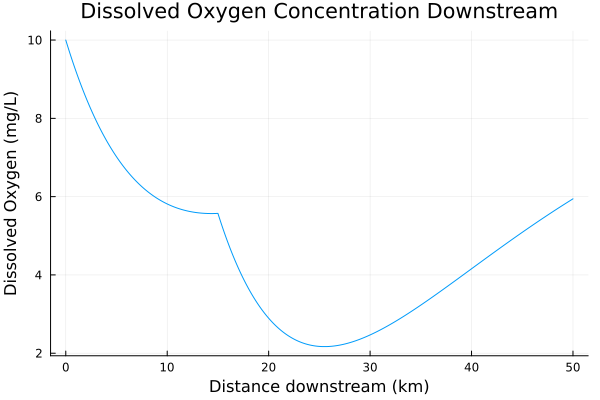

In [20]:
using Plots

# River
DO_s = 10.0              
K_dC = 0.35             
K_dN = 0.25              
K_r = 0.55              
v = 6.0                

# W2 joins
x2 = 15.0                
t2 = x2 / v                

x = 0.0:0.1:50.0          #distance
DO = similar(x)           

# IC
L_C1 = CBOD0
L_N1 = NBOD0

# Compute DO 
for (i, xi) in enumerate(x)
    t = xi / v          #Time
    if xi <= x2   # W1 only
        DC1 = (K_dC * L_C1) / (K_r - K_dC) * (exp(-K_dC * t) - exp(-K_r * t))
        DN1 = (K_dN * L_N1) / (K_r - K_dN) * (exp(-K_dN * t) - exp(-K_r * t))
        D = DC1 + DN1
    else   # W1 and W2
        DC1 = (K_dC * L_C1) / (K_r - K_dC) * (exp(-K_dC * t) - exp(-K_r * t))
        DN1 = (K_dN * L_N1) / (K_r - K_dN) * (exp(-K_dN * t) - exp(-K_r * t))

     
        CBOD1_x2 = L_C1 * exp(-K_dC * t2)
        NBOD1_x2 = L_N1 * exp(-K_dN * t2)
        DO1_x2 = DO_s - (DC1 + DN1)

        # After W2 joins
        Q2 = Q1 + Q_w2
        CBOD0_2 = (Q1 * CBOD1_x2 + Q_w2 * CBOD_w2) / Q2
        NBOD0_2 = (Q1 * NBOD1_x2 + Q_w2 * NBOD_w2) / Q2
        L_C2 = CBOD0_2
        L_N2 = NBOD0_2
        t_adjusted = t - t2

        # Deficits from W2
        DC2 = (K_dC * L_C2) / (K_r - K_dC) * (exp(-K_dC * t_adjusted) - exp(-K_r * t_adjusted))
        DN2 = (K_dN * L_N2) / (K_r - K_dN) * (exp(-K_dN * t_adjusted) - exp(-K_r * t_adjusted))

        D = DC1 + DN1 + DC2 + DN2
    end
    DO[i] = DO_s - D
end

min_DO = minimum(DO)
min_index = argmin(DO)
min_x = x[min_index]
println("The minimum DO concentration is $(round(min_DO, digits=2)) mg/L at $(round(min_x, digits=2)) km downstream.")

# Plot 
plot(x, DO, xlabel="Distance downstream (km)", ylabel="Dissolved Oxygen (mg/L)",
     title="Dissolved Oxygen Concentration Downstream", legend=false)

    

Part 2: We need to determine the minimum percentage of organic waste removal from one waste stream that ensures the DO concentration never drops below 4 mg/L. We assess each waste stream separately while keeping the other untreated. We reduce the CBOD and NBOD concentrations by varying the removal percentage, then recalculate the initial conditions after the first waste stream enters the river. The DO model is re-run using these new initial conditions, and we iteratively increase the removal percentage until the minimum DO concentration reaches at least 4 mg/L.



In [35]:
function compute_DO_with_treatment_W1(removal_percent)
    # Adjusted CBOD and NBOD for W1
    CBOD_w1_adj = CBOD_w1 * (1 - removal_percent / 100)
    NBOD_w1_adj = NBOD_w1 * (1 - removal_percent / 100)

    # New IC
    CBOD0_adj = (Q_river * CBOD_river + Q_w1 * CBOD_w1_adj) / Q1
    NBOD0_adj = (Q_river * NBOD_river + Q_w1 * NBOD_w1_adj) / Q1
    L_C1_adj = CBOD0_adj
    L_N1_adj = NBOD0_adj

    DO_adj = zeros(n)
    for i in 1:n
        xi = x[i]
        t = xi / v
        if xi <= x2
            # only change W1
            D_C1 = (K_dC * L_C1_adj) / (K_r - K_dC) * (exp(-K_dC * t) - exp(-K_r * t))
            D_N1 = (K_dN * L_N1_adj) / (K_r - K_dN) * (exp(-K_dN * t) - exp(-K_r * t))
            D = D_C1 + D_N1
        else
            t1 = t  # Time W1
            t2_adjusted = t - t2  # Time W2

            # Residual BOD from W1
            L_C1_res = L_C1_adj * exp(-K_dC * t2)
            L_N1_res = L_N1_adj * exp(-K_dN * t2)

            # After mixing
            Q2 = Q1 + Q_w2
            CBOD0_2 = (Q1 * L_C1_res + Q_w2 * CBOD_w2) / Q2
            NBOD0_2 = (Q1 * L_N1_res + Q_w2 * NBOD_w2) / Q2

            # DO deficits
            D_C1 = (K_dC * L_C1_adj) / (K_r - K_dC) * (exp(-K_dC * t1) - exp(-K_r * t1))
            D_N1 = (K_dN * L_N1_adj) / (K_r - K_dN) * (exp(-K_dN * t1) - exp(-K_r * t1))
            D_C2 = (K_dC * CBOD0_2) / (K_r - K_dC) * (exp(-K_dC * t2_adjusted) - exp(-K_r * t2_adjusted))
            D_N2 = (K_dN * NBOD0_2) / (K_r - K_dN) * (exp(-K_dN * t2_adjusted) - exp(-K_r * t2_adjusted))
            D = D_C1 + D_N1 + D_C2 + D_N2
        end
        DO_adj[i] = DO_s - D
    end
    return DO_adj
end
# find numbers
for removal_percent in 0:1:100
    DO_adj = compute_DO_with_treatment_W1(removal_percent)
    if minimum(DO_adj) >= 4.0
        println("Minimum treatment level for waste stream 1 to keep DO above 4 mg/L is $removal_percent%.")
        break
    end
end


Minimum treatment level for waste stream 1 to keep DO above 4 mg/L is 74%.


In [41]:
function compute_DO_with_treatment_W2(removal_percent)
    DO_adj = zeros(n)
    for i in 1:n
        xi = x[i]
        t = xi / v
        if xi <= x2
            D_C1 = (K_dC * L_C1) / (K_r - K_dC) * (exp(-K_dC * t) - exp(-K_r * t))
            D_N1 = (K_dN * L_N1) / (K_r - K_dN) * (exp(-K_dN * t) - exp(-K_r * t))
            D = D_C1 + D_N1
        else
            t1 = t  # Time W1
            t2_adjusted = t - t2  # Time W2

            # Residual BOD from W1 at x2
            L_C1_res = L_C1 * exp(-K_dC * t2)
            L_N1_res = L_N1 * exp(-K_dN * t2)

            # Adjusted W2 concentrations
            CBOD_w2_adj = CBOD_w2 * (1 - removal_percent / 100)
            NBOD_w2_adj = NBOD_w2 * (1 - removal_percent / 100)

            # After mixing with new W2
            Q2 = Q1 + Q_w2
            CBOD0_2 = (Q1 * L_C1_res + Q_w2 * CBOD_w2_adj) / Q2
            NBOD0_2 = (Q1 * L_N1_res + Q_w2 * NBOD_w2_adj) / Q2

            # DO deficits
            D_C1 = (K_dC * L_C1) / (K_r - K_dC) * (exp(-K_dC * t1) - exp(-K_r * t1))
            D_N1 = (K_dN * L_N1) / (K_r - K_dN) * (exp(-K_dN * t1) - exp(-K_r * t1))
            D_C2 = (K_dC * CBOD0_2) / (K_r - K_dC) * (exp(-K_dC * t2_adjusted) - exp(-K_r * t2_adjusted))
            D_N2 = (K_dN * NBOD0_2) / (K_r - K_dN) * (exp(-K_dN * t2_adjusted) - exp(-K_r * t2_adjusted))
            D = D_C1 + D_N1 + D_C2 + D_N2
        end
        DO_adj[i] = DO_s - D
    end
    return DO_adj
end
# find numbers
for removal_percent in 0:1:100
    DO_adj = compute_DO_with_treatment_W2(removal_percent)
    if minimum(DO_adj) >= 4.0
        println("Minimum treatment level for waste stream 2 to keep DO above 4 mg/L is $removal_percent%.")
        break
    end
end


Minimum treatment level for waste stream 2 to keep DO above 4 mg/L is 78%.


Part 3: Consider three options: treating waste stream 1 alone, treating waste stream 2 alone, or treating both streams equally. Treating both streams equally might be a more balanced approach.We modify the model to adjust both waste streams by the same removal percentage and iterate to find the minimum equal removal percentage that maintains DO above 4 mg/L. Lower removal percentages may result in reduced treatment costs. A shared responsibility approach might be more financially feasible for both waste generators. A cost-benefit analysis, technical feasibility studies, environmental assessments, and stakeholder engagement are important information to make decisions.  


In [39]:
function compute_DO_with_equal_treatment(removal_percent)
    # Adjusted CBOD and NBOD for both 
    CBOD_w1_adj = CBOD_w1 * (1 - removal_percent / 100)
    NBOD_w1_adj = NBOD_w1 * (1 - removal_percent / 100)
    CBOD_w2_adj = CBOD_w2 * (1 - removal_percent / 100)
    NBOD_w2_adj = NBOD_w2 * (1 - removal_percent / 100)

    # new IC
    CBOD0_adj = (Q_river * CBOD_river + Q_w1 * CBOD_w1_adj) / Q1
    NBOD0_adj = (Q_river * NBOD_river + Q_w1 * NBOD_w1_adj) / Q1
    L_C1_adj = CBOD0_adj
    L_N1_adj = NBOD0_adj

    DO_adj = zeros(n)
    for i in 1:n
        xi = x[i]
        t = xi / v
        if xi <= x2
            # Adjusted W1
            D_C1 = (K_dC * L_C1_adj) / (K_r - K_dC) * (exp(-K_dC * t) - exp(-K_r * t))
            D_N1 = (K_dN * L_N1_adj) / (K_r - K_dN) * (exp(-K_dN * t) - exp(-K_r * t))
            D = D_C1 + D_N1
        else
            t1 = t  # Time W1
            t2_adjusted = t - t2  # Time W2

            # Residual BOD from W1 at x2
            L_C1_res = L_C1_adj * exp(-K_dC * t2)
            L_N1_res = L_N1_adj * exp(-K_dN * t2)

            # After mixing with adjusted W2
            Q2 = Q1 + Q_w2
            CBOD0_2 = (Q1 * L_C1_res + Q_w2 * CBOD_w2_adj) / Q2
            NBOD0_2 = (Q1 * L_N1_res + Q_w2 * NBOD_w2_adj) / Q2

            # DO deficits
            D_C1 = (K_dC * L_C1_adj) / (K_r - K_dC) * (exp(-K_dC * t1) - exp(-K_r * t1))
            D_N1 = (K_dN * L_N1_adj) / (K_r - K_dN) * (exp(-K_dN * t1) - exp(-K_r * t1))
            D_C2 = (K_dC * CBOD0_2) / (K_r - K_dC) * (exp(-K_dC * t2_adjusted) - exp(-K_r * t2_adjusted))
            D_N2 = (K_dN * NBOD0_2) / (K_r - K_dN) * (exp(-K_dN * t2_adjusted) - exp(-K_r * t2_adjusted))
            D = D_C1 + D_N1 + D_C2 + D_N2
        end
        DO_adj[i] = DO_s - D
    end
    return DO_adj
end
# finding numbers
for removal_percent in 0:1:100
    DO_adj = compute_DO_with_equal_treatment(removal_percent)
    if minimum(DO_adj) >= 4.0
        println("Minimum equal treatment level for both waste streams to keep DO above 4 mg/L is $removal_percent%.")
        break
    end
end


Minimum equal treatment level for both waste streams to keep DO above 4 mg/L is 38%.


### Problem 2 (20 points)

The simplest climate model involves capturing changes to the Earth’s
energy budget (it is commonly called the *energy balance model*, or
EBM). These changes are also called *radiative forcings* (RF), and can
result from several causes, including greenhouse gas emissions, volcanic
eruptions, and changes to the solar cycle. The EBM treats the Earth as a
0-dimensional sphere covered with water, which absorbs heat in response
to radiative forcings. Chanwith global temperature changes resulting
from imbalances in the average (over the entire surface area) heat flux.

The EBM equations are:

$$
\begin{align*}
\overbrace{\frac{dH}{dt}}^{\text{change in heat}} &= \overbrace{F}^{\substack{\text{radiative} \\ \text{forcing}}} - \overbrace{\lambda T}^{\substack{\text{change in} \\ \text{temperature}}} \\
\underbrace{C}_{\substack{\text{ocean heat} \\ \text{capacity}}} \frac{dT}{dt} &= F - \lambda T \\
c\underbrace{d}_{\substack{\text{ocean} \\ \text{mixing depth}}} \frac{dT}{dt} &= F - \lambda T,
\end{align*}
$$

where $c = 4.184\times 10^6 \mathrm{J/K/m}^2$ is the specific heat of
water per area, $d$ is the depth of the ocean mixed layer (we’ll assume
$d = 86 \mathrm{m}$), and $\lambda$ is the **climate feedback factor**
and controls how much the Earth warms in response to increased radiative
forcing (assume
$\lambda = 2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2$)). The total
radiative forcing $F = F_\text{non-aerosol} + \alpha F_\text{aerosol}$,
where $\alpha$ is an uncertain scaling factor reflecting aerosol-cloud
feedbacks (we’ll assume $\alpha = 0.8$).

The code below loads historical and projected radiative forcings (under
the SSP5-8.5 future emissions scenario, which is the most extreme of the
scenarios used to project climate change impacts) from
`data/ERF_ssp585_1750-2500.csv` into a `DataFrame` object and calculates
the non-aerosol and aerosol components of those forcings.

> **Tip**
>
> Look closely at and experiment with the code below: `DataFrames` are a
> common Julia datatype for tabular data, and you may work more with
> them later in the semester or beyond! They are broadly similar to
> `DataFrames` from `pandas` in Python.

In [27]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
# Calculate non-aerosol forcings from the total.
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

751-element Vector{Float64}:
  0.25918289716993287
  0.24176756635599128
  0.21325975144045076
  0.17850291224529793
  0.1457411149414377
  0.09840432796857469
 -0.13383410588305977
  0.01724897551757567
  0.14777213389926366
  0.22712653379357609
  ⋮
 12.638871538651715
 12.636828023749903
 12.634811388909599
 12.632786007467395
 12.630739504290775
 12.628694395288093
 12.626673788131408
 12.624680005793559
 12.623637075242984

We can plot the aerosol and non-aerosol forcings below.

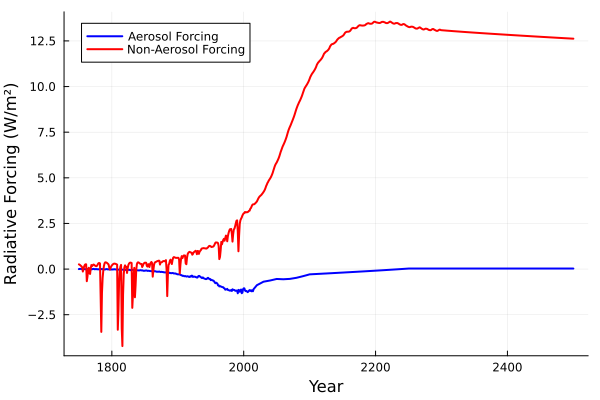

In [28]:
t = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers
p_forcing = plot(; xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(p_forcing, t, forcing_aerosol, label="Aerosol Forcing", color=:blue, linewidth=2)
plot!(p_forcing, t, forcing_non_aerosol, label="Non-Aerosol Forcing", color=:red, linewidth=2)

**In this problem**:

-   Discretize the EBM to produce a simulation model of global mean
    temperatures $T$ over time as a result of total radiative forcings
    $F$.

-   Simulate global mean temperature anomalies (in $^\circ C$ relative
    to 1750) from your model using the historical and SSP5-8.5 radiative
    forcing data. Use an annual time step for the simulation (in
    seconds: $\Delta t = 31,558,152 \mathrm{s}$). You can assume
    $T(0) = 0^\circ C$. Plot the resulting temperature simulation.

-   The climate feedback factor $\lambda$ is one of the key
    uncertainties in projecting future temperatures, even assuming a
    particular scenario of future radiative forcing. Suppose we use the
    following distribution for $\lambda$,
    $$\lambda \sim \text{LogNormal}(\log(2.1), \log(2)/4).$$

    Use Monte Carlo simulation to estimate the expected temperature in
    2100 assuming SSP5-RCP 8.5 radiative forcings (with 95% confidence
    intervals). How does this estimate compare to the value you got from
    your simulation using the expected value of
    $\lambda=2.1^\circ \mathrm{C}/(\mathrm{W}/\mathrm{m}^2)$? How did
    you decide your sample set was sufficient?

Part 1:
C*dT/dt = F(t)-lambda T(t)
Tn+1=Tn+deltat(Fn-lamdaTn/C)
Part 2: With the discretized EBM ready, the next step is to simulate global temperature anomalies using real data. The historical and projected radiative forcings from the SSP5-8.5 scenario are loaded, and aerosol and non-aerosol forcings are separated for better understanding of their individual impacts. Using the discretized equation, the temperature anomaly is updated year by year from 1750 to 2500, where each update step accounts for both aerosol and non-aerosol forcings. The simulation outputs a time series of temperature anomalies that reflects how the Earth's temperature evolves in response to changing forcings. This allows for a visual representation of global temperature trends over time.
Part 3:
The next task is to account for the uncertainty in the climate feedback factor 
𝜆
λ, which is an important but uncertain parameter in the model. To address this, a Monte Carlo simulation is performed where 
𝜆
λ is sampled from a LogNormal distribution in each simulation run. This approach generates many different possible temperature trajectories, reflecting different potential values for 
𝜆
λ. By running thousands of simulations, we can calculate the expected global temperature in 2100 as well as the 95% confidence interval. This method allows us to capture the variability in future temperature projections, providing a more realistic range of possible outcomes rather than a single deterministic result.

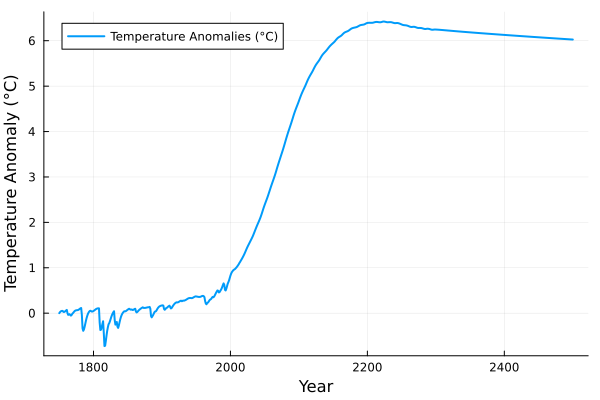

In [44]:
using CSV, DataFrames, Plots

# Data
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Constants
c = 4.184e6       
d = 86           
C = c * d         
lambda_mean = 2.1 
alpha = 0.8        
dt = 31_558_152  

# Separate the forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol

# Initialize temperature and time 
T = zeros(length(forcings_all[!,"year"]))  # Temperature anomalies
years = forcings_all[!,"year"]

# Simulate temperature anomalies 
for t in 2:length(years)
    F = forcing_non_aerosol[t] + alpha * forcing_aerosol[t]  
    T[t] = T[t-1] + dt/C * (F - lambda_mean * T[t-1])       

# Plot the temperature anomalies over time
p_temp = plot(years, T, label="Temperature Anomalies (°C)", xlabel="Year", ylabel="Temperature Anomaly (°C)", linewidth=2)
display(p_temp)


In [45]:
using Distributions, Statistics

# Define the distribution for lambda
lambda_dist = LogNormal(log(2.1), log(2)/4)

n_simulations = 1000  # Number of Monte Carlo simulations
T_mc = zeros(n_simulations)  # Store the temperature in 2100 for each simulation

# Monte Carlo Simulation 
for i in 1:n_simulations
    lambda_sample = rand(lambda_dist)  
    T_temp = 0.0  # IC
    for t in 2:length(years)
        F = forcing_non_aerosol[t] + alpha * forcing_aerosol[t]
        T_temp = T_temp + dt/C * (F - lambda_sample * T_temp)  # Euler step with sampled lambda
    end
    T_mc[i] = T_temp  # Record the temperature anomaly in 2100
end

# Calculate the mean and 95% confidence interval 
T_mean = mean(T_mc)
T_95_ci = quantile(T_mc, [0.025, 0.975])

# Results
println("Expected Temperature in 2100: $(round(T_mean, digits=3)) °C")
println("95% Confidence Interval: [$(round(T_95_ci[1], digits=3)), $(round(T_95_ci[2], digits=3))] °C")


Expected Temperature in 2100: 6.121 °C
95% Confidence Interval: [4.295, 8.573] °C


### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

A factory is planning a third wastewater discharge into the river
downstream of the second plant. This discharge would consist of 5
m<sup>3</sup>/day of wastewater with a dissolved oxygen content of 4.5
mg/L and CBOD and NBOD levels of 50 and 45 mg/L, respectively.

**In this problem**:

-   Assume that the treatment plan you identified in Problem 1 is still
    in place for the existing discharges. If the third discharge will
    not be treated, under the original inflow conditions (7.5 mg/L DO),
    how far downstream from the second discharge does this third
    discharge need to be placed to keep the river concentration from
    dropping below 4 mg/L?

## References

List any external references consulted, including classmates.